# Big Data Bandits

A Project-Group of the DHBW Karlsruhe participating in a AI-powerd World.

# In wie weit ist Marktmanipulation durch Privatpersonen auf Sozialmedia möglich?

Im folgenden Abstract soll dieser Frage nachgegangen werden.
Dafür betrachten wir insbesondere die Beziehungen zwischen dem Aktienkurs der Kryptowährung **Dogecoin (DGCN)**, sowie dem Nutzungsverhalten von **Elon Musk** auf der Plattform **X** (ehemalig Twitter).
Dabei ist uns natürlich bewusst, dass Elon Musk aufgrund seiner Reichweite und Popularität eine sehr dominate und übergeordnete Rolle spielt. Jedoch zeigt genau dieses Beispiel interresante und unerwartete Zusammenhänge.

Zu Beginn der Analyse werden die Datensätzte in einen Pandas Dataframe eingelsesen.

In [2]:
import pandas as pd

from analize import *

Posts:pd.DataFrame = pd.read_csv('./datasets/elonmusk.csv')
Tesla:pd.DataFrame = pd.read_csv('./datasets/tesla.csv')
Dogecoin:pd.DataFrame = pd.read_csv('./datasets/dogecoin.csv')

Im Weiteren definieren wir ein paar Hilfsfunktionen, die uns kleinere Nebenberechnungen im Verlauf der Analyse abnehmen.  
So berechnet z.B.: die Funktion **get_trade_day_avg()** den Durchschnittlichen Handelspreis einer Aktie für einen bestimmten Tag. 

In [3]:
import datetime
import pandas as pd

def check_filter(text:str, filter_list:list, hit:bool):
    for filter in filter_list:
        if filter in text:
            return hit
    return not hit


def get_trade_day_avg(date:datetime, stock:pd.DataFrame):
    trade_day = stock.loc[stock['date'] == str(date.strftime('%Y-%m-%d'))]

    if trade_day.empty:
        return None
    
    else:

        trade_day_open = trade_day.open.item()
        trade_day_close = trade_day.close.item()
        trade_day_avg = (trade_day_open + trade_day_close) / 2

        return trade_day_avg


def get_dates(date:datetime, interval_length:int=5):
    dates = []

    for i in range(0, interval_length):
        date += datetime.timedelta(days=i)
        dates.append(date)

    return dates

Die nachfolgende Funktion **get_trend()** ist ein wichtiges Kernstück der Analyse. Denn diese Funktion ermittelt mit Hilfe einer linearen Regression eine Gerade, welche das Wachstum einer Aktie für einem gegebenen Zeitraum repräsentiert. Standart ist hierbei ein Zeitraum von 5 Tagen.

In [4]:
import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def get_trend(date:datetime, stock:pd.DataFrame, interval_length:int=5):
    dates:list = get_dates(date, interval_length) 
    avgs:list = []

    for date_i in dates:
        avg = get_trade_day_avg(date_i, stock)
        if avg == None:
            return None
        else:
            avgs.append(avg)
    
    x = np.array(list(range(0, interval_length))).reshape((-1, 1))
    y = np.array(avgs)

    model = LinearRegression().fit(x, y)

    start_price_model = model.predict([[0]])[0]
    end_price_model = model.predict([[interval_length]])[0]

    change_percentage = round((end_price_model / start_price_model), 4)

    return [change_percentage, avgs, dates, (start_price_model, end_price_model)]

In [5]:
def get_influences(stock:pd.DataFrame, Posts:pd.DataFrame=Posts, filter_list:list=[], hit:bool=False,):
    influences:pd.DataFrame = pd.DataFrame(columns=['date', 'posts', 'count_posts', 'trend'])
    j = 0
    old_date = None

    for i, Post in Posts.iterrows():
        if not check_filter(str(Post['text']), filter_list, hit=hit):
            continue
        else:
            #Convert Datetime-string, to Date-object
            date = datetime.datetime.strptime(str(Post['datetime'])[0:18], '%Y-%m-%d %H:%M:%S').date()
            
            if date != old_date:
                ret = get_trend(date, stock)
                if ret == None:
                    continue
                else:
                    trend, avgs, dates, model = ret
                    influences.loc[j] = [date] + [[Post['text']]] + [0] + [trend]
                    old_date = date
                    j += 1
            else:
                influences.loc[j-1, 'posts'].append(Post['text'])
                influences.loc[j-1, 'count_posts'] += 1
    return [influences, j/i*100]


In [6]:
influences1, part1 = get_influences(Dogecoin, Posts, ["dodgecoin", "Dodgecoin", "dodge", "coin"], False)
influences2, part2 = get_influences(Dogecoin, Posts, ["dodgecoin", "Dodgecoin", "dodge", "coin"], True)

influences3, part3 = get_influences(Tesla, Posts, ["Tesla", "Car"], False)
influences4, part4 = get_influences(Tesla, Posts, ["Tesla", "Car"], True)

influencesM1, partM1 = get_influences(Dogecoin, Posts, [], False)
influencesM2, partM2 = get_influences(Tesla, Posts, [], False)

([<matplotlib.patches.Wedge at 0x5e0fc650>,
 [Text(-1.0890867630328989, 0.1545639757075448, ''),
  Text(1.0890867539883196, -0.15456403943733313, '')])

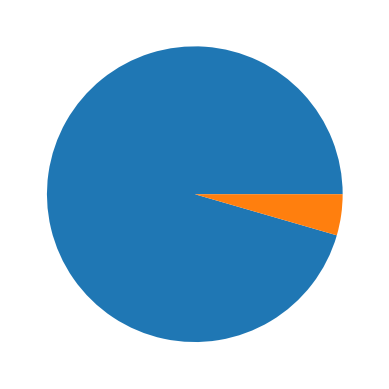

In [7]:
import matplotlib.pyplot as plt
plt.pie([part1, part2])

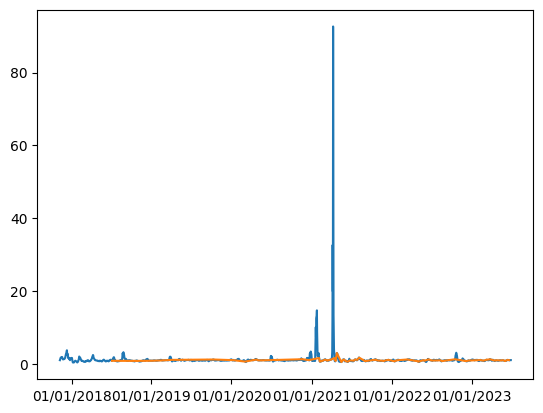

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))

plt.plot(influences1['date'], influences1['trend'])
plt.plot(influences2['date'], influences2['trend'])

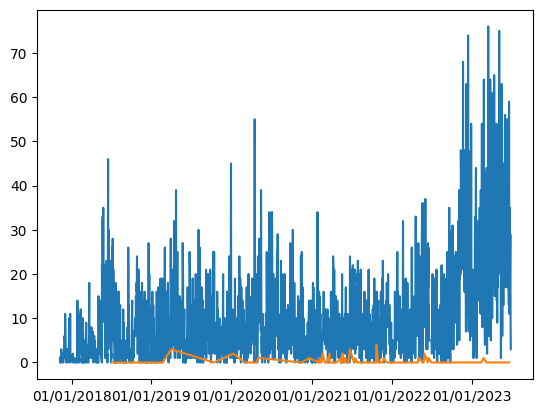

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))

plt.plot(influences1['date'], influences1['count_posts'])
plt.plot(influences2['date'], influences2['count_posts'])

<BarContainer object of 2 artists>

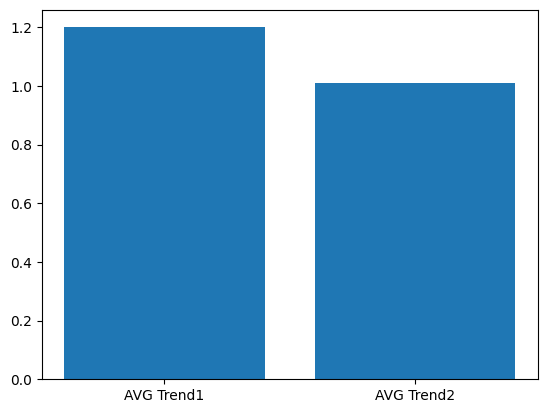

In [10]:
import matplotlib.pyplot as plt

labels = ["AVG Trend1", "AVG Trend2"]
avgs_trends = [influences1.loc[:, 'trend'].mean(), influences2.loc[:, 'trend'].mean()]

plt.bar(labels, avgs_trends)